## 1. Import Libraries and Setup

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [3]:
# The parameter names must match the pipeline step names, e.g., 'classifier__max_depth'
# TODO: Define base models (Decision Tree, kNN, Logistic Regression)

param_grid_dt = {
    'select__k': [5,10,15],
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'select__k': [5,10,15],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
}

param_grid_lr = {
    'select__k': [5,10,15],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'lbfgs']
}

# ToDo: Create a list of (classifier, param_grid, name) tuples
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree"),
    (KNeighborsClassifier(), param_grid_knn, "kNN"),
    (LogisticRegression(max_iter=200, random_state=42), param_grid_lr, "Logistic Regression"),
]

## Dataset Loading Function

### Wine Quality Testing

In [4]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

## Manual Grid Search

In [5]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # 1) Adjust feature selection grid so 'k' ≤ n_features
        adjusted_grid = param_grid.copy()
        if 'select__k' in adjusted_grid:
            adjusted_grid['select__k'] = [k for k in adjusted_grid['select__k'] if k <= n_features]
            if not adjusted_grid['select__k']:
                adjusted_grid['select__k'] = [min(n_features, 5)]  # safe fallback

        # Guard: if any grid list is empty, skip this classifier
        if any(len(v) == 0 for v in adjusted_grid.values()):
            print(f"Skipping {name}: no valid hyperparameter combinations after adjustment.")
            continue

        # 2) Enumerate all combinations
        keys = list(adjusted_grid.keys())
        values = [adjusted_grid[k] for k in keys]

        for combo in itertools.product(*values):
            params = dict(zip(keys, combo))
            scores = []

            # 3) CV loop
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('select', SelectKBest(score_func=f_classif)),
                    ('classifier', classifier_instance)
                ])

                pipeline.set_params(**params)
                pipeline.fit(X_tr, y_tr)

                # Some classifiers may not implement predict_proba (all 3 do), but guard anyway
                if hasattr(pipeline, 'predict_proba'):
                    y_proba = pipeline.predict_proba(X_val)[:, 1]
                else:
                    # Fallback: use decision_function then min-max normalize to [0,1]
                    decision = pipeline.decision_function(X_val)
                    dmin, dmax = decision.min(), decision.max()
                    y_proba = (decision - dmin) / (dmax - dmin + 1e-12)

                auc = roc_auc_score(y_val, y_proba)
                scores.append(auc)

            if len(scores) == 0:
                print(f"No valid folds for params {params} on {name}")
                continue

            mean_auc = float(np.mean(scores))

            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params

        print("-" * 90)
        if best_params is None:
            print(f"No valid parameter set found for {name}. Skipping.")
            continue

        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        # Final pipeline with consistent step name 'select' to match grid keys
        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('select', SelectKBest(score_func=f_classif)),
            ('classifier', classifier_instance)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)

        best_estimators[name] = final_pipeline

    return best_estimators

## Built-In Grid Sreach

In [6]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Adjust 'select__k' for dataset size
        adjusted_grid = param_grid.copy()
        if 'select__k' in adjusted_grid:
            adjusted_grid['select__k'] = [k for k in adjusted_grid['select__k'] if k <= n_features]
            if not adjusted_grid['select__k']:
                adjusted_grid['select__k'] = [min(n_features, 5)]

        # Guard
        if any(len(v) == 0 for v in adjusted_grid.values()):
            print(f"Skipping {name}: no valid hyperparameter combinations after adjustment.")
            continue

        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('select', SelectKBest(score_func=f_classif)),
            ('classifier', classifier_instance)
        ])

        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)

        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': float(grid_search.best_score_),
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin


## Model Evaluation and Voting Classifiers

In [7]:
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
# Guard: if no models were passed, skip evaluation to avoid NaNs
    if len(best_estimators) == 0:
        print("No fitted models provided; skipping evaluation.")
        return None, None

    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if True:  # Use soft voting by averaging probabilities for both methods
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        pass  # (not used)

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Complete Pipeline Function

In [8]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Execute Wine Quality Dataset


################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
------------------------------

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY
--- Manual Grid Search for Decision Tree ---
------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'select__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5}
Best cross-validation AUC: 0.7832
--- Manual Grid Search for kNN ---
------------------------------------------------------------------------------------------
Best parameters for kNN: {'select__k': 5, 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Best cross-validation AUC: 0.8642
--- Manual Grid Search for Logistic Regression ---
-----

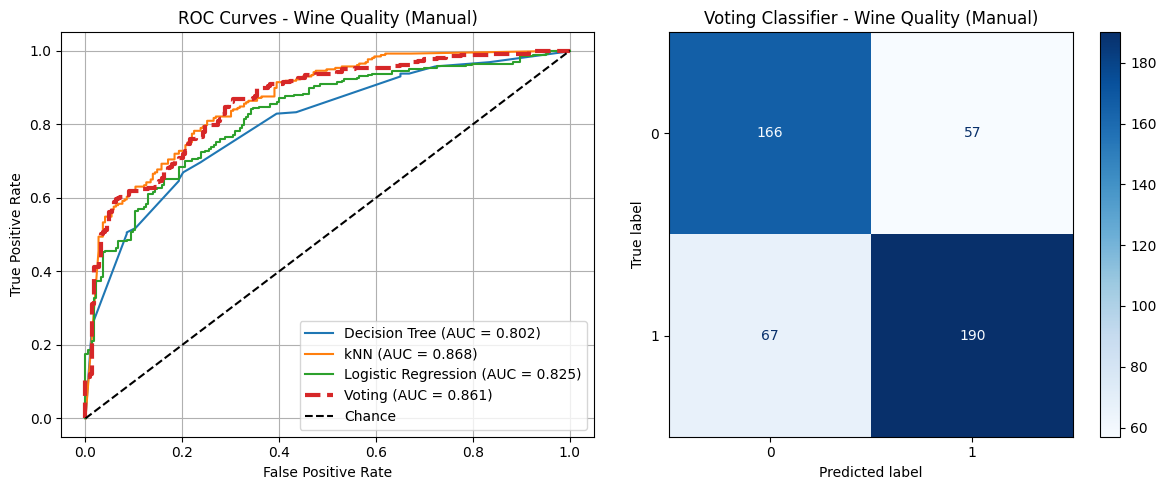


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'select__k': 5}
Best CV score: 0.7832

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'select__k': 5}
Best CV score: 0.8642

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'select__k': 10}
Best CV score: 0.8049

EVALUATING BUILT-IN MODELS FOR WINE QUALITY

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.7271
  Precision: 0.7716
  Recall: 0.6965
  F1-Score: 0.7321
  ROC AUC: 0.8025

kNN:
  Accuracy: 0.7750
  Precision: 0.7854
  Recall: 0.7977
  F1-Score: 0.7915
  ROC AUC: 0.8679

Logistic Regression:
  Accuracy: 0.7396
  Precision: 0.7619
  Recall: 0.7471
  F1-Score: 0.7544
  ROC AUC: 0.8246

--- Built-

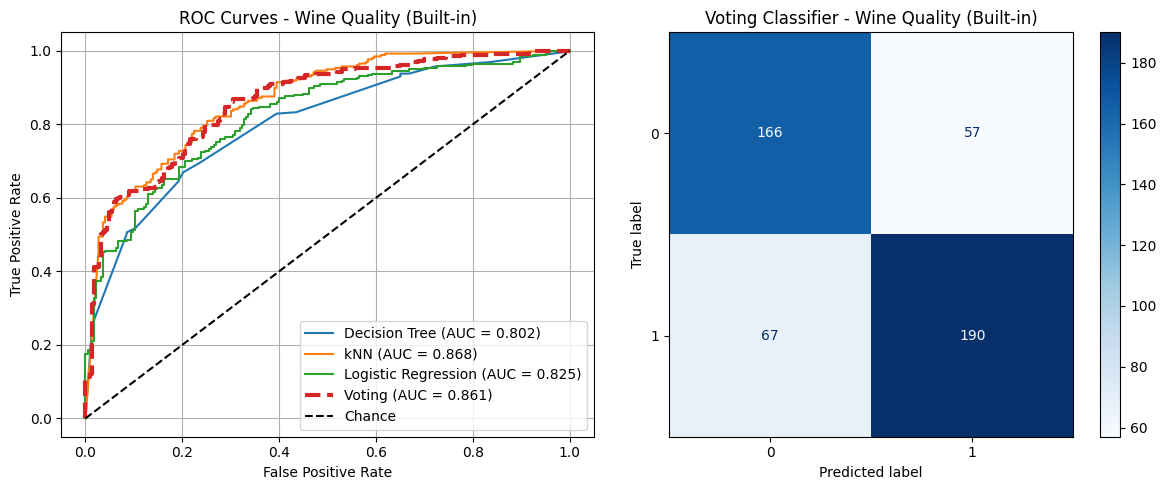


Completed processing for Wine Quality

ALL DATASETS PROCESSED!


In [9]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality"),
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)